In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [31]:
train_folder = os.path.join("data_FER", "train")
test_path = os.path.join("data_FER", "test")
validation_folder = os.path.join("data_FER", "validation")
img_size = 224

In [37]:
import cv2
import os

def resize_images_in_place(folder_path, target_size=(224, 224)):
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)

        if os.path.isdir(class_path):
            # Iterate over each image in the class folder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                # Ensure it's a file (an image)
                if os.path.isfile(img_path):
                    # Read, resize, and overwrite the original image
                    img = cv2.imread(img_path)
                    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
                    cv2.imwrite(img_path, resized_img)

    print("All images resized to", target_size, "and saved in place.")

In [43]:
for fold in os.listdir(validation_folder):
    path = os.path.join(train_folder, fold)
    resize_images_in_place(path)

All images resized to (224, 224) and saved in place.
All images resized to (224, 224) and saved in place.
All images resized to (224, 224) and saved in place.
All images resized to (224, 224) and saved in place.
All images resized to (224, 224) and saved in place.
All images resized to (224, 224) and saved in place.
All images resized to (224, 224) and saved in place.


In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
batch_size = 64
 
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

nb_train_samples = train_generator.n  
nb_validation_samples = validation_generator.n  

Found 20452 images belonging to 7 classes.
Found 6291 images belonging to 7 classes.


In [91]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV3Small

In [94]:
mobilenet_model = MobileNetV3Small(
    input_shape = (224, 224, 3),
    alpha=1.0,
    #minimalistic=False,
    include_top=False,
    weights="imagenet",
    #dropout_rate=0.2,
    #classifier_activation="softmax",
    include_preprocessing=False,
)

for layers in mobilenet_model.layers:
    layers.trainable = False

In [95]:
#mobilenet_model.summary()

In [96]:
def custom_layers(bottom_model, num_class):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dropout(0.15)(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    #top_model = Dropout(0.1)(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(16,activation='relu')(top_model)
    top_model = Dense(num_class,activation='softmax')(top_model)
    return top_model

In [97]:
num_class = 7
top_model = custom_layers(mobilenet_model, num_class)
model = Model(inputs = mobilenet_model.input, outputs = top_model)

In [98]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 112, 112, 16)      │             432 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 112, 112, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_36 (Activation)    │ (None, 112, 112, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_pad   │ (None, 113, 113, 16)      │               0 │ activation_36[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 56, 56, 16)        │             144 │ expanded_conv_depthwise_p… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 56, 56, 16)        │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_28 (ReLU)               │ (None, 56, 56, 16)        │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │               0 │ re_lu_28[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │             136 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │               0 │ expanded_conv_squeeze_exc… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │             144 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_18 (Add)                  │ (None, 1, 1, 16)          │               0 │ expanded_conv_squeeze_exc… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_29 (ReLU)               │ (None, 1, 1, 16)          │               

 Total params: 1,105,719 (4.22 MB)

 Trainable params: 165,959 (648.28 KB)

 Non-trainable params: 939,760 (3.58 MB)

In [99]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name='Adam',
)

#loss="categorical_crossentropy" -> alculates the difference between the true labels and the predicted probability distribution for each class.
#                                -> Penalises the model more heavily when it assigns more probablity to the correct class
model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])

In [106]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("face_recogV3_final4.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [108]:
import time

start = time.time()
epochs = 20
#train_generator = train_generator.repeat()

history = model.fit(train_generator, 
                    batch_size = batch_size,
                    epochs=epochs,  
                    callbacks = callbacks,
                    shuffle = True,
                    validation_data= validation_generator)
print("Total time: ", time.time() - start, "seconds")

C:\Users\dlr22\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 82/320 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.1968 - loss: 2.1403

KeyboardInterrupt: 

In [ ]:
new_model.save('emotion_model.h5')

In [110]:
!python --version

Python 3.10.0


In [ ]:
new_model = tf.keras.models.load_model('emotion_model.h5')

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = new_model.predict(x)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step
Accuracy: 0.1608108108108108


In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
frame  = cv2.imread('happyboi.jpg')

In [ ]:
frame.shape

(408, 612, 3)

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
gray.shape

(408, 612)

In [ ]:
face = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in face:
  roi_gray = gray[y:y+h,x:x+w]
  roi_color = frame[y:y+h,x:x+w]
  cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
  faces = faceCascade.detectMultiScale(roi_gray)
  if len(faces) == 0:
    print("Face not detected")
  else:
    for (ex,ey,ew,eh) in faces:
      face_roi = roi_color[ey: ey+eh, ex: ex + ew]

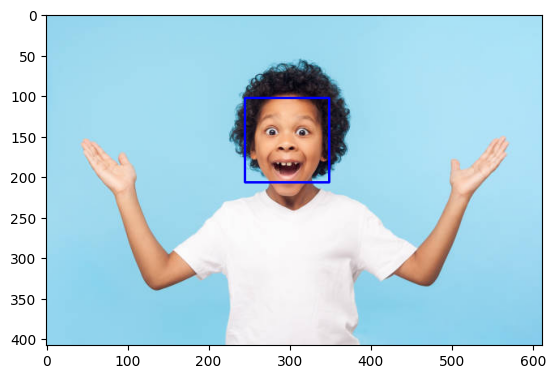

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
final_image = cv2.resize(face_roi,(224,224))
final_image = np.expand_dims(final_image,axis = 0)
final_image = final_image/255.0

In [ ]:
Predictions = new_model.predict(final_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
Predictions[0]

array([7.4611826e-08, 8.4866683e-11, 5.5302739e-06, 1.9622396e-06,
       1.9258634e-06, 4.5734541e-09, 9.9999046e-01], dtype=float32)

In [ ]:
np.argmax(Predictions[0])

6

In [ ]:
# prompt: now write the code to read a video and detect the emotion in each frame and there should be a rectangle around the face and text should be shown near the rectangle showing which emotion is detected. The output should be saved as a video with name 'final.mp4' , no need to display output in code

import cv2
import numpy as np
from tensorflow import keras

# Load the pre-trained emotion detection model
new_model = keras.models.load_model('emotion_model.h5')

# Load the Haar cascade classifier for face detection
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Open the video file
video_path = '/content/drive/MyDrive/Classroom/Sample.mp4'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('final1.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = frame[y:y + h, x:x + w]

        # Resize the face ROI for the model input
        final_image = cv2.resize(roi_color, (224, 224))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image / 255.0

        # Make prediction using the model
        predictions = new_model.predict(final_image)
        predicted_emotion = emotion_labels[np.argmax(predictions[0])]

        # Draw rectangle around the face and display emotion label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Write the frame to the output video file
    out.write(frame)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━